# LinkedIn Job Postings

## ADS 508 Impacting the Business with a Distributed Data Science Pipeline

In [8]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
from pyathena import connect
import awswrangler as wr

import warnings
warnings.filterwarnings('ignore')

## Data Ingestion

### CSV to S3

In [9]:
# Setup boto3 session parameters
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

# Establish connection
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [10]:
# Set S3 Source Location (Public bucket)
s3_public_path = "s3://linkedin-postings"

In [11]:
%store s3_public_path

Stored 's3_public_path' (str)


In [12]:
# Set S3 Destination Location (Private bucket)
s3_private_path = "s3://{}/linkedin_data".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-937572952481/linkedin_data


In [13]:
%store s3_private_path

Stored 's3_private_path' (str)


In [14]:
# Copy data from Public S3 bucket to Private S3 bucket
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "postings/postings.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "salaries/salaries.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "job_skills/job_skills.csv"

copy: s3://linkedin-postings/postings/postings.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/postings/postings.csv
copy: s3://linkedin-postings/salaries/salaries.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/salaries/salaries.csv
copy: s3://linkedin-postings/job_skills/job_skills.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/job_skills/job_skills.csv


In [15]:
# Check files are copied successfully to private bucket
!aws s3 ls $s3_private_path/

                           PRE job_skills/
                           PRE postings/
                           PRE salaries/


### Create Athena Database 

In [16]:
ingest_create_athena_db_passed = False

In [17]:
ingest_create_athena_table_passed = False

In [18]:
database_name = "linkedin_data"

In [19]:
# Set S3 staging directory - a temporary directory for Athena queries
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

In [20]:
# Connect to staging directory
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [21]:
# Create Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

""


### Verify database has been created

In [22]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,linkedin_data


In [23]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena Tables from CSV Files

In [91]:
table_name = 'postings'
postings_path = "s3://{}/linkedin_data/postings/".format(bucket)

drop_statement = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name)

print(drop_statement)
pd.read_sql(drop_statement, conn)
print("Attempted to Drop {} table".format(table_name))

DROP TABLE IF EXISTS linkedin_data.postings;
Attempted to Drop postings table


In [92]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        company_name string,
        title string,
        description string,
        max_salary float,
        pay_period string,
        location string,
        company_id float,
        views float,
        med_salary float,
        min_salary float,
        formatted_work_type string,
        applies float,
        original_listed_time float,
        remote_allowed float,
        job_posting_url string,
        application_url string,
        application_type string,
        expiry float,
        closed_time float,
        formatted_experience_level string,
        skills_desc string,
        listed_time string,
        posting_domain string,
        sponsored int,
        work_type string,
        currency string,
        compensation_type string,
        normalized_salary float,
        zip_code int,
        fips int
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, postings_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created postings table")

Created postings table


In [93]:
table_name_2 = "salaries"
salaries_path = "s3://{}/linkedin_data/salaries/".format(bucket)

drop_statement2 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_2)

print(drop_statement2)
pd.read_sql(drop_statement2, conn)
print("Attempted to Drop {} table".format(table_name_2))

DROP TABLE IF EXISTS linkedin_data.salaries;
Attempted to Drop salaries table


In [94]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        salary_id int,
        job_id string,
        max_salary float,
        med_salary float,
        min_salary float,
        pay_period string,
        currency string,
        compensation_type string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_2, salaries_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created salaries table")

Created salaries table


In [95]:
table_name_3 = "job_skills"
job_skills_path = "s3://{}/linkedin_data/job_skills/".format(bucket)

drop_statement3 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_3)

print(drop_statement3)
pd.read_sql(drop_statement3, conn)
print("Attempted to Drop {} table".format(table_name_3))

DROP TABLE IF EXISTS linkedin_data.job_skills;
Attempted to Drop job_skills table


In [96]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        skill_abr string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_3, job_skills_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created job_skills table")

Created job_skills table


### Verify tables have been created successfully

In [97]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,job_skills
1,postings
2,salaries


In [98]:
if table_name in df_show.values:
    ingest_create_athena_table_passed = True

In [99]:
# View postings table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name)

print(statement)

SELECT * FROM linkedin_data.postings LIMIT 5


In [100]:
postings_df = pd.read_sql(statement, conn)
postings_df

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,3904958473,"""Lowe's Companies","Inc.""",Full Time - Sales Specialist - Millwork - Day,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,All Lowe’s associates deliver quality customer...,safe,and stocked with the products our customers n...,this means:,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Being friendly and professional,eager to understand the customer’s specific n...,operates as intended during demonstrations,and is up to date,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [101]:
# View salaries table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name_2)

salaries_df = pd.read_sql(statement, conn)
salaries_df

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3884428798,NaN,20.0,NaN,HOURLY,USD,BASE_SALARY
1,2,3887470552,25.0,NaN,23.0,HOURLY,USD,BASE_SALARY
2,3,3884431523,120000.0,NaN,100000.0,YEARLY,USD,BASE_SALARY
3,4,3884911725,200000.0,NaN,10000.0,YEARLY,USD,BASE_SALARY
4,5,3887473220,35.0,NaN,33.0,HOURLY,USD,BASE_SALARY


In [102]:
# View job skills table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name_3)

job_skills_df = pd.read_sql(statement, conn)
job_skills_df

,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


## Data Exploration

### postings EDA

In [103]:
# Basic stats
print(postings_df.describe())
print(postings_df.info())

       job_id       company_name   title  \
count       5                  3       3   
unique      4                  3       3   
top            "Lowe's Companies   Inc."   
freq        2                  1       1   

                                          description max_salary pay_period  \
count                                               3          0          0   
unique                                              3          0          0   
top     Full Time - Sales Specialist - Millwork - Day        NaN        NaN   
freq                                                1        NaN        NaN   

       location company_id views med_salary  ... skills_desc listed_time  \
count         0          0     0          0  ...           0           0   
unique        0          0     0          0  ...           0           0   
top         NaN        NaN   NaN        NaN  ...         NaN         NaN   
freq        NaN        NaN   NaN        NaN  ...         NaN         NaN   

  

In [104]:
# Data types
postings_data_types = postings_df.dtypes
print(postings_data_types)

job_id                        object
company_name                  object
title                         object
description                   object
max_salary                    object
pay_period                    object
location                      object
company_id                    object
views                         object
med_salary                    object
min_salary                    object
formatted_work_type           object
applies                       object
original_listed_time          object
remote_allowed                object
job_posting_url               object
application_url               object
application_type              object
expiry                        object
closed_time                   object
formatted_experience_level    object
skills_desc                   object
listed_time                   object
posting_domain                object
sponsored                     object
work_type                     object
currency                      object
c

In [105]:
# Missing values
postings_df.isnull().sum()

job_id                        0
company_name                  2
title                         2
description                   2
max_salary                    5
pay_period                    5
location                      5
company_id                    5
views                         5
med_salary                    5
min_salary                    5
formatted_work_type           5
applies                       5
original_listed_time          5
remote_allowed                5
job_posting_url               5
application_url               5
application_type              5
expiry                        5
closed_time                   5
formatted_experience_level    5
skills_desc                   5
listed_time                   5
posting_domain                5
sponsored                     5
work_type                     5
currency                      5
compensation_type             5
normalized_salary             5
zip_code                      5
fips                          5
dtype: i

In [106]:
# Duplicates
postings_df.duplicated().sum()

1

In [107]:
# Summary statistics
print(f"Unique Job Titles: {postings_df['title'].nunique()}")
print(f"Unique Companies: {postings_df['company_name'].nunique()}")

Unique Job Titles: 3
Unique Companies: 3


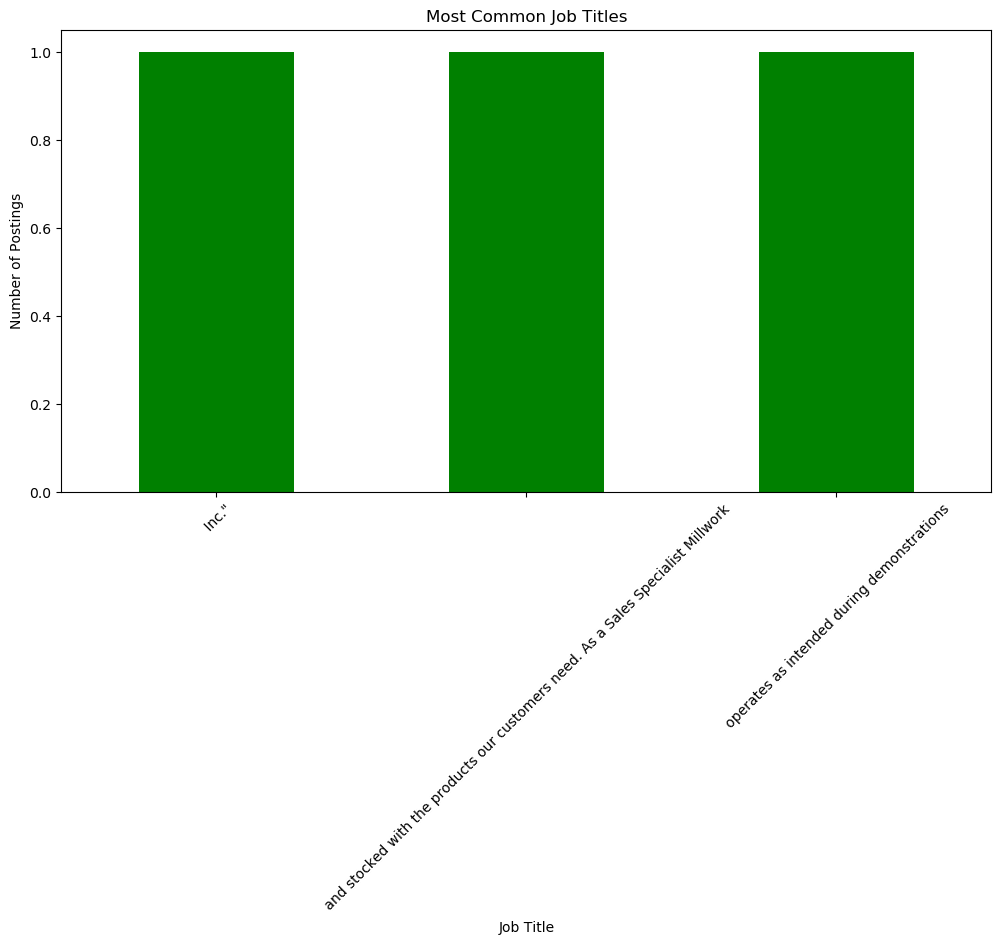

In [108]:
# Visualize most common job titles
plt.figure(figsize=(12,6))
postings_df['title'].value_counts().head(10).plot(kind='bar', color='green')
plt.xlabel("Job Title")
plt.ylabel("Number of Postings")
plt.title("Most Common Job Titles")
plt.xticks(rotation=45)
plt.show()

In [109]:
# Posting trends
postings_df['listed_time'] = postings_df.to_datetime(postings_df['listed_time'], unit='s')  # Convert Unix timestamp to datetime
postings_df.set_index('listed_time', inplace=True)

# Resample by month to see posting trends
postings_df.resample('M').size().plot(figsize=(12, 5), title="Job Posting Trends Over Time")
plt.ylabel("Number of Postings")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'to_datetime'

### salaries EDA

In [110]:
# Basic stats
print(salaries_df.describe())
print(salaries_df.info())

       salary_id     max_salary  med_salary     min_salary
count   5.000000       4.000000         1.0       4.000000
mean    3.000000   80015.000000        20.0   27514.000000
std     1.581139   97963.260035         NaN   48552.105461
min     1.000000      25.000000        20.0      23.000000
25%     2.000000      32.500000        20.0      30.500000
50%     3.000000   60017.500000        20.0    5016.500000
75%     4.000000  140000.000000        20.0   32500.000000
max     5.000000  200000.000000        20.0  100000.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary_id          5 non-null      int64  
 1   job_id             5 non-null      object 
 2   max_salary         4 non-null      float64
 3   med_salary         1 non-null      float64
 4   min_salary         4 non-null      float64
 5   pay_period         5 non-nul

In [111]:
# Data types
salaries_data_types = salaries_df.dtypes
print(salaries_data_types)

salary_id              int64
job_id                object
max_salary           float64
med_salary           float64
min_salary           float64
pay_period            object
currency              object
compensation_type     object
dtype: object


In [112]:
# Missing values
salaries_df.isnull().sum()

salary_id            0
job_id               0
max_salary           1
med_salary           4
min_salary           1
pay_period           0
currency             0
compensation_type    0
dtype: int64

In [113]:
# Duplicates
salaries_df.duplicated().sum()

0

In [114]:
# Salary distributions
print("Max Salary: ", salaries_df['max_salary'].describe())
print("Min Salary: ", salaries_df['min_salary'].describe())
print("Median Salary: ", salaries_df['med_salary'].describe())
# print(df[['min_salary', 'med_salary', 'max_salary', 'normalized_salary']].describe())

Max Salary:  count         4.000000
mean      80015.000000
std       97963.260035
min          25.000000
25%          32.500000
50%       60017.500000
75%      140000.000000
max      200000.000000
Name: max_salary, dtype: float64
Min Salary:  count         4.000000
mean      27514.000000
std       48552.105461
min          23.000000
25%          30.500000
50%        5016.500000
75%       32500.000000
max      100000.000000
Name: min_salary, dtype: float64
Median Salary:  count     1.0
mean     20.0
std       NaN
min      20.0
25%      20.0
50%      20.0
75%      20.0
max      20.0
Name: med_salary, dtype: float64


In [115]:
# Visualize salary distribution
plt.figure(figsize=(10,5))
sns.barplot(df['normalized_salary'], bins=30, kde=True, color="blue")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.title("Salary Distribution")
plt.show()

KeyError: 'normalized_salary'

<Figure size 1000x500 with 0 Axes>

### job_skills EDA

In [116]:
# Basic stats
print(job_skills_df.describe())
print(job_skills_df.info())

            job_id skill_abr
count            5         5
unique           3         5
top     3884428798      MRKT
freq             3         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job_id     5 non-null      object
 1   skill_abr  5 non-null      object
dtypes: object(2)
memory usage: 212.0+ bytes
None


In [117]:
# Data types
job_skills_data_types = job_skills_df.dtypes
print(job_skills_data_types)

job_id       object
skill_abr    object
dtype: object


In [118]:
# Missing values
job_skills_df.isnull().sum()

job_id       0
skill_abr    0
dtype: int64

In [119]:
# Duplicates
job_skills_df.duplicated().sum()

0

In [120]:
# Summary statistics
print(f"Unique Job Skills: {job_skills_df['skill_abr'].nunique()}")

Unique Job Skills: 5


In [122]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 22.5 MB/s eta 0:00:00


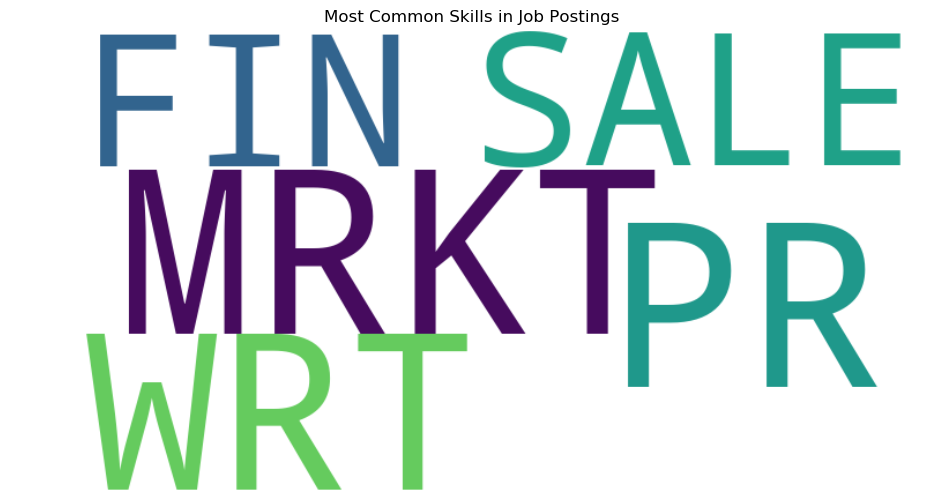

In [124]:
from collections import Counter
from wordcloud import WordCloud

# Concatenate all skills descriptions
all_skills = " ".join(str(skill) for skill in job_skills_df['skill_abr'].dropna())

# Count word frequencies
word_counts = Counter(all_skills.split())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)

# Visualize most common job skills in job descriptions
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Skills in Job Postings")
plt.show()

### Bias Analysis

In [125]:
# Detecting Skewed Data in Job Roles shown above
# Detecting salary bias shown above

In [126]:
# Detecting Biased Language in Job Descriptions (might favor aggressive hiring cultures)

# List of biased words to check
biased_words = ["dominant", "aggressive", "competitive", "strong leader"]

# Count biased words in descriptions
word_counts = Counter(" ".join(str(desc) for desc in postings_df['description'].dropna()).lower().split())

# Filter for biased words
biased_word_freq = {word: word_counts[word] for word in biased_words if word in word_counts}

# Visualize word frequency
plt.figure(figsize=(10,5))
sns.barplot(x=list(biased_word_freq.keys()), y=list(biased_word_freq.values()), palette="Reds_r")
plt.xlabel("Biased Words")
plt.ylabel("Frequency")
plt.title("Occurrence of Potentially Biased Words in Job Descriptions")
plt.show()

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<Figure size 1000x500 with 0 Axes>